In [1]:
!nvidia-smi

Thu Nov 24 13:03:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:19:00.0 Off |                  N/A |
| 30%   35C    P5    48W / 350W |      3MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
| 30%   

In [ ]:
##
# Похоже в этом ноутбуке (Pretraining.v6.ipynb) наиболее правильная версия предобучения на TUH. Тимур прислал 14/09/2023
# Тут коррекные лоссы и possition encoder
# К сожалению эта версия  не совпадает с тем что Тимур расшарил как финальную версию  /home/sokhin/notebooks/HSE_stage2/pretraining/ Pretraining.v5.ipynb

##### %config Completer.use_jedi = False

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ['http_proxy'] = "http://127.0.0.1:3128"
# os.environ['https_proxy'] = "http://127.0.0.1:3128"

In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import os

In [4]:
from torch.utils.tensorboard import SummaryWriter

In [5]:
import torch
from bert_conv_custom import BertConfig, BertEncoder

In [6]:
from transformers import BertModel

# Architecture

In [7]:
class TransposeCustom(torch.nn.Module):
    def __init__(self):
        super(TransposeCustom, self).__init__()
        
    def forward(self, x):
        return torch.transpose(x, 1, 2)

In [8]:
# config = BertConfig(is_decoder=True, 
#                     add_cross_attention=True,
#                     ff_layer='conv',
#                     conv_kernel=1,
#                     conv_kernel_num=3)

In [9]:
def _make_span_from_seeds(seeds, span, total=None):
    inds = list()
    for seed in seeds:
        for i in range(seed, seed + span):
            if total is not None and i >= total:
                break
            elif i not in inds:
                inds.append(int(i))
    return np.array(inds)

In [10]:
def _make_mask(shape, p, total, span, allow_no_inds=False):
    # num_mask_spans = np.sum(np.random.rand(total) < p)
    # num_mask_spans = int(p * total)
    mask = torch.zeros(shape, requires_grad=False, dtype=torch.bool)

    for i in range(shape[0]):
        mask_seeds = list()
        while not allow_no_inds and len(mask_seeds) == 0 and p > 0:
            mask_seeds = np.nonzero(np.random.rand(total) < p)[0]

        mask[i, _make_span_from_seeds(mask_seeds, span, total=total)] = True

    return mask

In [11]:
import math
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 6000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [12]:
class InputEmbedder(torch.nn.Module):
    def __init__(self, hidden_size=768, chnls=10):
        super().__init__()
        self.pos_encoder = PositionalEncoding(chnls)
        
        self.embedder = torch.nn.Sequential(
            TransposeCustom(),
            torch.nn.Conv1d(in_channels=chnls, out_channels=chnls, groups=chnls, kernel_size=4, dilation=2, stride=2),
            torch.nn.Conv1d(in_channels=chnls, out_channels=chnls, groups=chnls, kernel_size=7, dilation=3, stride=2),
            torch.nn.Conv1d(in_channels=chnls, out_channels=chnls, groups=chnls, kernel_size=11, dilation=5, stride=2),
        )
        
        self.time_self_attention_embedder = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=chnls, out_channels=32, kernel_size=3, dilation=1, stride=1, padding=1),
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, dilation=1, stride=1),
            torch.nn.ReLU6(),
            torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, dilation=1, stride=1, padding=1),
            torch.nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, dilation=1, stride=1),
            torch.nn.ReLU6(),
            torch.nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, dilation=1, stride=1, padding=1),
            torch.nn.Conv1d(in_channels=512, out_channels=hidden_size, kernel_size=1, dilation=1, stride=1),
            torch.nn.ReLU6(),
            TransposeCustom(),
        )

        self.time_self_attention = torch.nn.MultiheadAttention(embed_dim=hidden_size, num_heads=12, batch_first=True)
        
        self.norm = torch.nn.LayerNorm(hidden_size)
        # attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # attention_probs = nn.Softmax(dim=-1)(attention_scores)
        # attention_probs = self.dropout(attention_probs
        
        
    def forward(self, x):
        x = self.pos_encoder(x)
        embedding = self.embedder(x)
        
        cross_channel_attention = torch.matmul(embedding, embedding.transpose(1, 2))
        cross_channel_attn_output = torch.matmul(cross_channel_attention, embedding)#.transpose(1, 2)
        
        cross_channel_attn_output = torch.nn.Softmax(-1)(cross_channel_attn_output)
        cross_channel_attn_output = torch.nn.Dropout()(cross_channel_attn_output)
        
        
        tsa_embedding = self.time_self_attention_embedder(cross_channel_attn_output)
        # print(cross_channel_attn_output.shape, tsa_embedding.shape)
        tsa_attn_output, tsa_attn_output_weights = self.time_self_attention(tsa_embedding, tsa_embedding, tsa_embedding)
        
        tsa_attn_output = self.norm(tsa_attn_output)
        
        return tsa_attn_output, tsa_attn_output_weights, cross_channel_attn_output

In [13]:
class EEGEmbedder(torch.nn.Module):
    def __init__(self, hidden_size=768, chnls=10):
        super(EEGEmbedder, self).__init__()
        self.input_embedder = InputEmbedder(hidden_size, chnls)
        
        config = BertConfig(is_decoder=False, 
                    add_cross_attention=False,
                    ff_layer='linear',
                    hidden_size=hidden_size,
                    num_attention_heads=8,
                    num_hidden_layers=4,
                    conv_kernel=1,
                    conv_kernel_num=1)
        self.model = BertEncoder(config)
        
        self.mask_embedding = torch.nn.Parameter(torch.normal(0, chnls**(-0.5), size=(chnls,)),
                                                   requires_grad=True)
        
        self.pooling = torch.nn.Sequential(
            TransposeCustom(),
            torch.nn.AdaptiveAvgPool1d((10))
        )
        
        self.classification = torch.nn.Sequential(
            # torch.nn.Linear(7680, 7680 // 2),
            torch.nn.Linear(hidden_size, 1),
        )
        
        self.upconvolution = torch.nn.Sequential(
            TransposeCustom(),
            torch.nn.ConvTranspose1d(in_channels=hidden_size, out_channels=512, kernel_size=10, dilation=5, stride=2, padding=0),
            torch.nn.ReLU6(),
            torch.nn.ConvTranspose1d(in_channels=512, out_channels=chnls * 10, kernel_size=8, dilation=4, stride=2, padding=0),
            torch.nn.ReLU6(),
            torch.nn.ConvTranspose1d(in_channels=chnls * 10, out_channels=chnls, kernel_size=6, dilation=3, stride=2, padding=2, groups=chnls),
            torch.nn.ReLU6(),
            TransposeCustom(),
            torch.nn.LayerNorm(chnls)
        )
        
    def forward(self, inputs):
        inputs_masked = inputs.clone()
        mask = _make_mask((inputs.shape[0], inputs.shape[1]), 0.05, inputs.shape[1], 5)
        # print(mask.shape, inputs.shape)
        inputs_masked[mask] = self.mask_embedding
        
        # placeholder = torch.zeros_like(inputs_masks[:, :1])
        # placeholder[:, 0] = mask
        # inputs_masked = torch.
        
        embedding, tsa_attn_output_weights, cross_channel_attn_output = self.input_embedder(inputs_masked)
        plchldr = torch.zeros((embedding.shape[0], 1, embedding.shape[2])).to(embedding.device)
        embedding = torch.cat([plchldr, embedding], 1)

        encoder_output = self.model(embedding, output_hidden_states=True,
                               output_attentions=True)[0]
        
        # print(encoder_output.shape)
        # encoder_pooled = self.pooling(encoder_output).reshape(-1, 7680)
        negative_predict = self.classification(encoder_output)[:, 0]
        
        decoded_predict = self.upconvolution(encoder_output)
        
        return decoded_predict, negative_predict, mask

# Data

In [14]:
def _generate_negatives(z):
    """Generate negative samples to compare each sequence location against"""
    num_negatives = 20
    batch_size, feat, full_len = z.shape
    z_k = z.permute([0, 2, 1]).reshape(-1, feat)
    with torch.no_grad():
        # candidates = torch.arange(full_len).unsqueeze(-1).expand(-1, self.num_negatives).flatten()
        negative_inds = torch.randint(0, full_len-1, size=(batch_size, full_len * num_negatives))
        # From wav2vec 2.0 implementation, I don't understand
        # negative_inds[negative_inds >= candidates] += 1

        for i in range(1, batch_size):
            negative_inds[i] += i * full_len

    z_k = z_k[negative_inds.view(-1)].view(batch_size, full_len, num_negatives, feat)
    return z_k, negative_inds

In [15]:
def _calculate_similarity( z, c, negatives):
    c = c[..., :].permute([0, 2, 1]).unsqueeze(-2)
    z = z.permute([0, 2, 1]).unsqueeze(-2)

    # In case the contextualizer matches exactly, need to avoid divide by zero errors
    negative_in_target = (c == negatives).all(-1)
    targets = torch.cat([c, negatives], dim=-2)

    logits = torch.nn.functional.cosine_similarity(z, targets, dim=-1) / 0.1
    if negative_in_target.any():
        logits[1:][negative_in_target] = float("-inf")

    return logits.view(-1, logits.shape[-1])

In [16]:
def masking(ts):
    start_shift = np.random.choice(range(10))
    downsampling = 2
    indices = np.random.choice(np.array(list(range(110)))[start_shift::10][::downsampling], 5, replace=False)
    masked_idx = []
    for i in indices:
        masked_idx.extend(range(i, i+10))

    masked_idx = np.array(masked_idx)
    
    # mask = np.ones((6000, 2))
    # # desync some masked channels
    # ts_masked = ts.copy()
    # if np.random.choice([0, 1], p=[0.7, 0.3]):
    #     ts_masked[masked_idx, np.random.choice([0, 1])] *= 0
    # else:
    #     ts_masked[masked_idx] *= 0
        
    return None, masked_idx

In [17]:
writer = SummaryWriter('./logs')

2022-11-24 13:03:52.273845: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [18]:
class TEST(torch.utils.data.Dataset):
    def __init__(self, path):
        super(TEST, self).__init__()
        self.main_path = path
        self.paths = path
        # self.paths = ['{}/{}'.format(self.main_path, i) for i in os.listdir(self.main_path)]

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx, negative=False):
        path = self.paths[idx]
        # take 60s of recording with specified shift
        key = False
        while(key == False):
            try:
                sample = np.load(path, allow_pickle=True).item()['value']
                key = True
            except Exception as e:
                print("Path: {} is broken ".format(path), e)
                path = np.random.choice(self.paths, 1)[0]
                # sample = np.load(path, allow_pickle=True).item()['value']
        real_len = min(3000, sample.shape[0])
        # if np.random.choice([0, 1], p=[0.9, 0.1]):
        #     real_len = np.random.randint(real_len // 2, real_len)
            
        sample = sample[:real_len]
        # sample = torch.from_numpy(sample[:6000].astype(np.float32)).clone()
        channels_ids = [i for i, val in enumerate(mitsar_chls) if val not in ['FCZ', 'PZ']]
        
        # choose 2 random channels
        channels_to_train = channels_ids#np.random.choice(channels_ids, 2, replace=False)
        channels_vector = torch.tensor((channels_to_train))
        sample = sample[:, channels_to_train]
        
        sample_norm = (sample - tuh_filtered_stat_vals['mean_vals_filtered'][channels_vector]) / (tuh_filtered_stat_vals['std_vals_filtered'][channels_vector])
        # sample_norm = sample_norm * 2 - 1
        # _, mask = masking(sample_norm)
        if sample_norm.shape[0] < 3000:
            sample_norm = np.pad(sample_norm, ((0, 3000 - sample_norm.shape[0]), (0, 0)))
        
        if np.random.choice([0, 1], p=[0.7, 0.3]) and not negative:
            index = np.random.choice(self.__len__()-1)
            negative_sample = self.__getitem__(index, True)
            negative_path = negative_sample['path']
            
            split_point = np.random.randint(0, 2500)
            
            sample_norm[split_point:] = negative_sample['anchor'][:3000 - split_point]
            
            negative_person = negative_sample['path'].split('/')[-1]#.split('_')
            current_person = path.split('/')[-1]#.split('_')
            if negative_person.split('_')[0] == current_person.split('_')[0] and \
                abs(int(negative_person.split('_')[1][:-4]) - int(current_person.split('_')[1][:-4])) < 20000:
                negative_label = torch.tensor(0)
            else:
                negative_label = torch.tensor(1)
        else:
            negative_label = torch.tensor(0)
            negative_path = ''
        
        
        attention_mask = torch.ones(3000)
        attention_mask[real_len:] = 0
        return {'anchor': torch.from_numpy(sample_norm).float(),
                'path': path,
                'label': negative_label,
                'negative_path': negative_path,
                # 'label': sample_label, 
                # 'anchor_masked': torch.from_numpy(sample_masked).float(), 
                # 'mask': torch.tensor(mask),
                'channels': channels_vector,
                'attention_mask': attention_mask}

In [19]:
tuh_filtered_stat_vals = np.load('/home/data/TUH_pretrain.filtered_1_40/stat_vals.npy', allow_pickle=True).item()

In [20]:
tuh_filtered_stat_vals['max_vals_filtered']

array([ 929.30603427,  898.27363556,  870.97542454,    0.        ,
        845.25776129,  867.24068064,  881.13749063,  855.6903967 ,
        829.22225808,  813.37697722,  878.28132565,  840.11027797,
        849.28949468,  789.55156254,  853.53436091,  815.30186276,
        846.6759591 ,  809.75543712,  862.0800527 ,  823.89231015,
       1090.73060764, 1114.70090672])

In [21]:
# file_paths = []
# for path1 in os.listdir('/home/data/TUH_pretrain.filtered_1_40/'):
#     if 'npy' not in path1:
#         for path2 in os.listdir('/home/data/TUH_pretrain.filtered_1_40/{}'.format(path1)):
#             for path3 in os.listdir('/home/data/TUH_pretrain.filtered_1_40//{}/{}'.format(path1, path2)):
#                 file_paths.append('/home/data/TUH_pretrain.filtered_1_40//{}/{}/{}'.format(path1, path2, path3))

In [22]:
# len(file_paths)

In [23]:
# tmp = {}

# for path in file_paths:
#     tmp[path] = np.load(path, allow_pickle=True).item()

In [24]:
# sizes = np.load('/home/data/TUH_pretrain.filtered_1_40/sizes.npy', allow_pickle=True).item()

In [25]:
# file_paths = [i for i in file_paths if sizes[i][0] > 10000]

In [26]:
# splitted_paths = []
# for path in file_paths:
#     shape = sizes[path][0]
#     for i in range(0, shape, 6000):
#         if (shape - i > 6000):
#             splitted_paths.append((path, i))

In [27]:
splitted_paths = ['/home/data/TUH_pretrain.filtered_1_40.splited/{}'.format(i) for i in os.listdir('/home/data/TUH_pretrain.filtered_1_40.splited/')]

In [28]:
len(splitted_paths)

365495

In [29]:
mitsar_chls = ['Fp1', 'Fp2', 'FZ', 'FCz', 'Cz', 'Pz', 'O1', 'O2', 'F3', 'F4', 
               'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'P3', 'P4', 'T5', 'T6']
mitsar_chls = [i.upper() for i in mitsar_chls]

In [30]:
len(mitsar_chls)

20

In [31]:
test_dataset = TEST(splitted_paths)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)

# Training

In [32]:
model = EEGEmbedder(768, 18)

In [33]:

from torch.optim.lr_scheduler import _LRScheduler
class NoamLR(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, d_model=512):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
        super().__init__(optimizer)

    def get_lr(self):
        last_epoch = max(1, self.last_epoch)
        factor = min(last_epoch ** (-0.5), last_epoch * self.warmup_steps ** (-1.5))
        # scale = self.warmup_steps ** 0.5 * min(last_epoch ** (-0.5), last_epoch * self.warmup_steps ** (-1.5))
        # return [base_lr * scale for base_lr in self.base_lrs]
        return [base_lr * self.d_model ** (-0.5) * factor for base_lr in self.base_lrs]

In [34]:
cossim = torch.nn.CosineSimilarity(dim=-1)

def cosloss(anchor, real, negative):
    a = torch.exp(cossim(anchor, real)) / 0.1
    b = sum([torch.exp(cossim(anchor, negative[:, n])) / 0.1 for n in range(negative.shape[1])]) + 1e-6
    return -torch.log(a/b)

In [35]:
import random
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    np.random.seed((torch_seed + worker_id) % 2**30)

train_dataset = TEST(splitted_paths[:-15000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True, worker_init_fn = worker_init_fn)

test_dataset = TEST(splitted_paths[-15000:])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True, worker_init_fn = worker_init_fn)


In [36]:

model.train()

lr_d = 1e-4
acc_size = 1
training_epochs1 = 150000 // len(train_loader)

optim = torch.optim.AdamW(model.parameters(), lr=lr_d)

# model_test = torch.nn.DataParallel(model).to('cuda:0')
model_test = model.to('cuda:0')

loss_func = torch.nn.BCEWithLogitsLoss()
# scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=1.0, end_factor=0.1, total_iters=training_epochs1*len(train_loader))
# scheduler = NoamLR(optim, 100000, 768)

steps = 0

In [37]:
len(train_loader), training_epochs1, training_epochs1 * len(train_loader)

(10952, 13, 142376)

In [38]:
# model.cpu()(batch['anchor'][None], batch['mask'][None], batch['channels'][None])

In [39]:

for epoch in range(training_epochs1):
    mean_loss = 0
    acc_step = 0
    for batch in train_loader:
        # batch = train_dataset.__getitem__(i)
        # placeholder = torch.zeros((batch['anchor'].shape[0], 1, 512)) - 5
        ae, negative_predict, mask = model_test(
            batch['anchor'].to('cuda:0'))

        logits = _calculate_similarity(torch.transpose(batch['anchor'].to('cuda:0'), 1, 2), torch.transpose(ae, 1, 2), _generate_negatives(torch.transpose(batch['anchor'].to('cuda:0'), 1, 2))[0])

        fake_labels = torch.zeros(logits.shape[0], device=logits.device, dtype=torch.long)
        loss1 = torch.nn.CrossEntropyLoss()(logits, fake_labels) + 0.001 * batch['anchor'].pow(2).mean()
        loss2 = loss_func(negative_predict.view(-1), batch['label'].float().to('cuda:0'))
                          
        loss = loss1 + loss2
        
        loss = loss.mean()
        loss.backward()
        mean_loss += loss.item()
        acc_step += 1
        steps += 1
        # raise
        if acc_step != 0 and acc_step % acc_size == 0:
            optim.step()
            # scheduler.step()
            optim.zero_grad()
            if steps % 100 == 0:
                print('Loss/train\t{}'.format(mean_loss / acc_size))
            # writer.add_scalar('Loss/train', mean_loss / acc_size, steps)
            mean_loss = 0
        if steps != 0 and steps % 1000 == 0:
            der = 0
            try:
                with torch.no_grad():
                    for batch in test_loader:
                        # batch = test_dataset.__getitem__(i)
                        # placeholder = torch.zeros((batch['anchor'].shape[0], 1, 512)) - 5
                        ae, negative_predict, mask = model_test(
                            batch['anchor'].to('cuda:0'))

                        logits = _calculate_similarity(torch.transpose(batch['anchor'].to('cuda:0'), 1, 2), torch.transpose(ae, 1, 2), _generate_negatives(torch.transpose(batch['anchor'].to('cuda:0'), 1, 2))[0])

                        fake_labels = torch.zeros(logits.shape[0], device=logits.device, dtype=torch.long)
                        loss1 = torch.nn.CrossEntropyLoss()(logits, fake_labels) + 0.001 * batch['anchor'].pow(2).mean()
                        loss2 = loss_func(negative_predict.view(-1), batch['label'].float().to('cuda:0'))

                        loss = loss1 + loss2
                        loss = loss.mean() / acc_size
                        der += loss 
                der /= len(test_loader)
                # writer.add_scalar('Loss/test', der, steps)

                print('Loss: {}\t'.format(der))
            except:
                raise
            torch.save(model_test.state_dict(), 'models2/step_{}.pt'.format(steps))

Loss/train	8.694025039672852
Loss/train	9.006468772888184
Path: /home/data/TUH_pretrain.filtered_1_40.splited/217.npy is broken  Failed to interpret file '/home/data/TUH_pretrain.filtered_1_40.splited/217.npy' as a pickle
Loss/train	8.589913368225098
Loss/train	8.60503101348877
Loss/train	8.75553035736084
Loss/train	9.036945343017578
Loss/train	8.716285705566406
Loss/train	8.911067962646484
Loss/train	8.830413818359375
Loss/train	8.801209449768066
Loss: 8.709307670593262	
Loss/train	8.852030754089355
Loss/train	9.082815170288086
Loss/train	8.687589645385742
Loss/train	8.689347267150879
Loss/train	8.645638465881348
Loss/train	8.708474159240723
Loss/train	8.795748710632324
Loss/train	8.551420211791992
Loss/train	8.644699096679688
Loss/train	8.781282424926758
Loss: 8.620344161987305	
Loss/train	8.569984436035156
Loss/train	8.163372039794922
Loss/train	8.62979793548584
Loss/train	8.666812896728516
Loss/train	8.676263809204102
Loss/train	8.538572311401367
Loss/train	8.540146827697754
Loss/t

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1620888/1270484258.py:4 in <cell line: 1>                                         │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1620888/1270484258.py'                      │
│                                                                                                  │
│ /home/sokhin/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:530 in __next__   │
│                                                                                                  │
│    527 │   │   with torch.autograd.profiler.record_function(self._profile_name):                 │
│    528 │   │   │   if self._sampler_iter is None:                                                │
│    529 │   │   │   │   self._reset()                                                             │
│ ❱  530 │   │   │   data = self._next_data()                                                      │
│    531 │   │   │   self._num_yielded += 1                                                        │
│    532 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    533 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /home/sokhin/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:570 in _next_data │
│                                                                                                  │
│    567 │                                                                                         │
│    568 │   def _next_data(self):                                                                 │
│    569 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  570 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    571 │   │   if self._pin_memory:                                                              │
│    572 │   │   │   data = _utils.pin_memory.pin_memory(data)                                     │
│    573 │   │   return data                                                                       │
│                                                                                                  │
│ /home/sokhin/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:49 in fetch     │
│                                                                                                  │
│   46 │                                                                                           │
│   47 │   def fetch(self, possibly_batched_index):                                                │
│   48 │   │   if self.auto_collation:                                                             │
│ ❱ 49 │   │   │   data = [self.dataset[idx] for idx in possibly_batched_index]                    │
│   50 │   │   else:                                                                               │
│   51 │   │   │   data = self.dataset[possibly_batched_index]                                     │
│   52 │   │   return self.collate_fn(data)                                                        │
│                                                                                                  │
│ /home/sokhin/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:49 in           │
│ <listcomp>                                                                                       │
│                                                                                                  │
│   46 │                                                                                           │
│   47 │   def fetch(self, possibly_batched_index):          

In [1]:
loss2

NameError: name 'loss2' is not defined

In [41]:
loss

tensor(8.5244, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
ae.shape

torch.Size([32, 3000, 18])

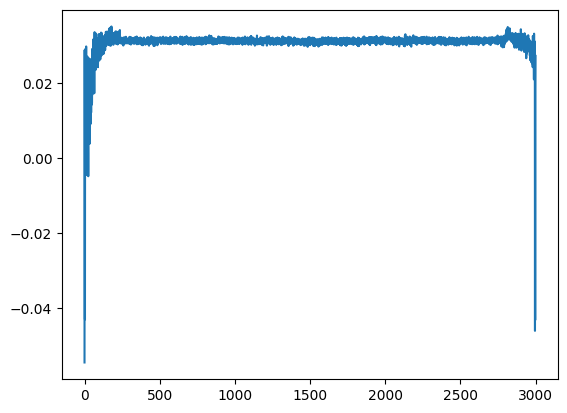

In [51]:
plt.plot(ae[0, ].mean(-1).cpu().detach() - 0.65)
# plt.plot(batch['anchor'][0, 500:1000].mean(-1).cpu().detach())
# plt.plot(batch['anchor'][0, 500:1500].mean(-1).cpu().detach())

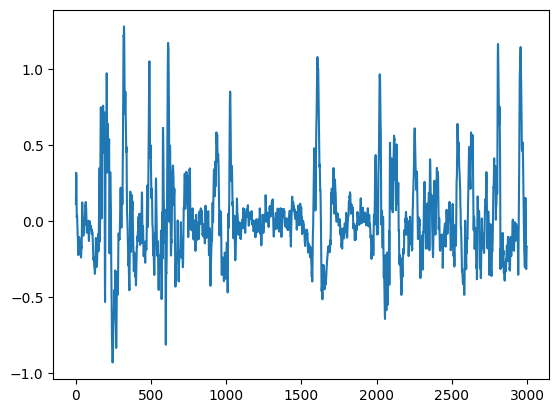

In [50]:
plt.plot(batch['anchor'][0, ].mean(-1).cpu().detach())

In [43]:
loss = torch.nn.CrossEntropyLoss()(logits, fake_labels) + 0.001 * batch['anchor'].pow(2).mean() + loss_func(negative_predict.view(-1), batch['label'].float().to('cuda:0'))


In [43]:
torch.nn.CrossEntropyLoss()(logits, fake_labels) + 0.001 * batch['anchor'].pow(2).mean()

tensor(7.9687, device='cuda:0')

In [44]:
loss_func(negative_predict.view(-1), batch['label'].float().to('cuda:0'))

tensor(0.5758, device='cuda:0')

In [45]:
negative_predict

tensor([[-0.7300],
        [-0.7316],
        [-0.7324],
        [-0.7309],
        [-0.7342],
        [-0.7273],
        [-0.7304],
        [-0.7323],
        [-0.7299],
        [-0.7295],
        [-0.7279],
        [-0.7357],
        [-0.7314],
        [-0.7340],
        [-0.7335],
        [-0.7299],
        [-0.7286],
        [-0.7305],
        [-0.7289],
        [-0.7307],
        [-0.7333],
        [-0.7324],
        [-0.7318],
        [-0.7296],
        [-0.7280],
        [-0.7309],
        [-0.7325],
        [-0.7319],
        [-0.7346],
        [-0.7337],
        [-0.7316],
        [-0.7294],
        [-0.7306],
        [-0.7286],
        [-0.7308],
        [-0.7305],
        [-0.7264],
        [-0.7320],
        [-0.7343],
        [-0.7321],
        [-0.7344],
        [-0.7303],
        [-0.7303],
        [-0.7315],
        [-0.7304],
        [-0.7325],
        [-0.7349],
        [-0.7312],
        [-0.7331],
        [-0.7316],
        [-0.7340],
        [-0.7329],
        [-0.

In [46]:
batch['label']

tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [45]:
batch['anchor']

tensor([[[ 3.8537e-01,  4.9493e-01,  1.3400e-01,  ...,  1.5627e-01,
           2.3715e-01,  2.8405e-01],
         [ 3.8345e-01,  5.7050e-01,  4.9959e-02,  ..., -4.3298e-02,
           1.4616e-01,  1.7546e-01],
         [-1.3037e-02,  3.3618e-01,  9.2427e-02,  ...,  5.3397e-02,
          -4.1969e-02, -2.5228e-02],
         ...,
         [-4.3905e-02, -1.3792e-02,  2.3695e-02,  ..., -1.0326e-02,
           2.3960e-02,  8.3773e-02],
         [ 2.1197e-02,  4.8220e-03, -1.8512e-02,  ..., -7.4642e-02,
           1.1582e-02,  6.3271e-02],
         [ 8.2315e-02,  4.4333e-02, -5.7898e-02,  ..., -5.3816e-02,
           2.0928e-02,  1.2479e-01]],

        [[ 1.5943e+00,  1.7968e+00,  1.8339e+00,  ...,  1.7956e+00,
           1.6506e+00,  1.8553e+00],
         [ 1.5728e+00,  1.7702e+00,  1.8218e+00,  ...,  1.7946e+00,
           1.6533e+00,  1.8761e+00],
         [ 1.1123e+00,  1.2596e+00,  1.3077e+00,  ...,  1.2802e+00,
           1.1812e+00,  1.3364e+00],
         ...,
         [-1.3362e+00, -1

In [57]:
steps

159219

In [47]:
np.load('/home/data/TUH_pretrain.filtered_1_40.splited/2990_174000.npy', allow_pickle=True)

array({'value': array([[ -3.85031008,   2.85196812,   2.07325583, ...,  -7.50037225,
        -10.90961471,  -8.02874688],
       [-14.41600966,  -6.85561872,  -1.99783744, ..., -12.02037489,
        -20.83239401,  -7.28345165],
       [-22.68984145, -16.19871822,  -5.15646806, ..., -17.4048751 ,
        -25.79506833, -21.20112015],
       ...,
       [  0.83328995,   6.0946769 ,  -1.01211029, ...,   5.56320695,
          3.40607593,   9.95040555],
       [ -5.23044887,   2.98819828,  -2.53847765, ...,   1.96995798,
          1.19625315,   6.24915094],
       [ -6.41559363,   0.44634677,  -3.84797447, ...,  -2.32357481,
         -2.30819229,  -0.28246068]]), 'date': 's004_2016_08_25', 'id': '147_00014747', 'ref_type': '01_tcp_ar', 'channels': ['FP1', 'FP2', 'FZ', 'FCZ', 'CZ', 'PZ', 'O1', 'O2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'P3', 'P4', 'T5', 'T6', 'A1', 'A2']},
      dtype=object)

In [37]:
model.train()

lr_d = 1e-5
acc_size = 1
training_epochs1 = 150000 // len(train_loader)

optim = torch.optim.AdamW(model.parameters(), lr=lr_d)

model_test = torch.nn.DataParallel(model)
model_test.to('cuda:0')

loss_func = torch.nn.MSELoss()

In [38]:

for epoch in range(training_epochs1):
    mean_loss = 0
    acc_step = 0
    for batch in train_loader:
        # batch = train_dataset.__getitem__(i)
        placeholder = torch.zeros((batch['anchor'].shape[0], 1, 512)) - 5
        ae, label = model_test(
            batch['anchor'],#.to('cuda:0'), 
            batch['mask'], 
            batch['channels'].long(),
            placeholder)#.to('cuda:0'))
        # loss_value = loss_fct(output, batch['labels'].to('cuda:0'))
        # loss_positive = loss_fct(ae, pe)
        # loss_negative = loss_fct(ae, ne)
        reshaped_indexed_real = []
        reshaped_indexed_pred = []
        reshaped_indexed_negative = []
        for b_i in range(ae.shape[0]):
            reshaped_indexed_pred.append(ae[b_i][batch['mask'][b_i][::10]][None])
            reshaped_indexed_real.append(label[b_i][batch['mask'][b_i][::10]][None])
            reshaped_indexed_negative.append(label[b_i][(batch['mask'][b_i] + 20) % 132][None])
        reshaped_indexed_pred = torch.cat(reshaped_indexed_pred, 0)
        reshaped_indexed_real = torch.cat(reshaped_indexed_real, 0)
        reshaped_indexed_negative = torch.cat(reshaped_indexed_negative, 0)
        # raise
        loss = cosloss(
            reshaped_indexed_pred, 
            reshaped_indexed_real, 
            reshaped_indexed_negative.reshape(
                reshaped_indexed_negative.shape[0], 
                reshaped_indexed_negative.shape[1] // 5, 
                reshaped_indexed_negative.shape[1] // 10, 
                reshaped_indexed_negative.shape[2]))
        # loss = loss_func(reshaped_indexed_pred[indexes_fine][:, :, :2], reshaped_indexed_real[indexes_fine][:, :, :2].to('cuda:0'))

        # hard_loss = loss[loss > 0.0]
        # if (len(hard_loss) == 0):
        #     hard_loss = loss
        # hard_loss = loss
        loss = loss.mean()
        loss.backward()
        mean_loss += loss.item()
        acc_step += 1
        steps += 1
        # raise
        if acc_step != 0 and acc_step % acc_size == 0:
            optim.step()
            scheduler.step()
            optim.zero_grad()
            if steps % 100 == 0:
                print('Loss/train\t{}'.format(mean_loss / acc_size))
            writer.add_scalar('Loss/train', mean_loss / acc_size, steps)
            mean_loss = 0
        if steps != 0 and steps % 1000 == 0:
            der = 0
            try:
                with torch.no_grad():
                    for batch in test_loader:
                        # batch = test_dataset.__getitem__(i)
                        placeholder = torch.zeros((batch['anchor'].shape[0], 1, 512)) - 5
                        ae, label = model_test(
                            batch['anchor'],#.to('cuda:0'), 
                            batch['mask'], 
                            batch['channels'].long(),#.to('cuda:0'),
                            placeholder)
                        # loss_positive = loss_fct(ae, pe)
                        # loss_negative = loss_fct(ae, ne)
                        reshaped_indexed_real = []
                        reshaped_indexed_pred = []
                        reshaped_indexed_negative = []
                        for b_i in range(ae.shape[0]):
                            reshaped_indexed_pred.append(ae[b_i][batch['mask'][b_i][::10]][None])
                            reshaped_indexed_real.append(label[b_i][batch['mask'][b_i][::10]][None])
                            reshaped_indexed_negative.append(label[b_i][(batch['mask'][b_i] + 20) % 132][None])
                        reshaped_indexed_pred = torch.cat(reshaped_indexed_pred, 0)
                        reshaped_indexed_real = torch.cat(reshaped_indexed_real, 0)
                        reshaped_indexed_negative = torch.cat(reshaped_indexed_negative, 0)

                        loss = cosloss(
                            reshaped_indexed_pred, 
                            reshaped_indexed_real, 
                            reshaped_indexed_negative.reshape(
                                reshaped_indexed_negative.shape[0], 
                                reshaped_indexed_negative.shape[1] // 5, 
                                reshaped_indexed_negative.shape[1] // 10, 
                                reshaped_indexed_negative.shape[2]))

                        loss = loss.mean() / acc_size
                        der += loss
                der /= len(test_loader)
                writer.add_scalar('Loss/test', der, steps)

                print('Loss: {}\t'.format(der))
            except:
                raise
            torch.save(model_test.module.state_dict(), 'models/step_{}.pt'.format(steps))

Loss/train	1.8929529190063477
Loss/train	1.9144232273101807
Loss/train	1.8872368335723877
Loss/train	1.898066759109497
Loss/train	1.9088211059570312
Loss/train	1.896066665649414
Loss/train	1.903018593788147
Loss/train	1.8914568424224854
Loss/train	1.903407096862793
Loss: 1.7999563217163086	
Loss/train	1.8804712295532227
Loss/train	1.8972877264022827
Loss/train	1.8831760883331299
Loss/train	1.9031308889389038
Loss/train	1.8904520273208618
Loss/train	1.9119493961334229
Loss/train	1.9052908420562744
Loss/train	1.896553874015808
Loss/train	1.9152153730392456
Loss/train	1.869958758354187
Loss: 1.7969849109649658	
Loss/train	1.8917416334152222
Loss/train	1.9191652536392212
Loss/train	1.8704347610473633
Loss/train	1.8648254871368408
Loss/train	1.8790819644927979
Loss/train	1.910555124282837
Loss/train	1.8742694854736328
Loss/train	1.905527949333191
Loss/train	1.8932743072509766
Loss/train	1.8955141305923462
Loss: 1.7965463399887085	
Loss/train	1.860345482826233
Loss/train	1.887194037437439
Lo

KeyboardInterrupt: 